In [12]:
# pip install wheel pickle5 pandas biopython matplotlib bs4

import io, os, re, time, math, urllib, Bio.PDB, sys, pandas as pd
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, PandasTools, Draw, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D, MolDraw2D
from rdkit.Geometry.rdGeometry import Point3D
PandasTools.RenderImagesInAllDataFrames(images=True)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
from IPython.core.display import display, HTML, SVG
display(HTML("<style>.container { width:100% !important; }</style>")) 

op = rdMolDraw2D.MolDrawOptions() # https://rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html?#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions
op.bondLineWidth=2
op.maxFontSize=18
op.minFontSize=18
#op.legendFontSize=18
op.fillHighlights=False
op.fixedBondLength=30
op.centreMoleculesBeforeDrawing=True
op.atomHighlightsAreCircles = True  
op.fontFile = os.path.join(RDConfig.RDCodeDir, 'Chem', 'Draw', 'FreeSans.ttf') # Amadeus.ttf | Telex-Regular.ttf

In [13]:
def AaToSVG(res,part): 
    m = Chem.MolFromSmiles(f'C{part}')
    m = rdMolDraw2D.PrepareMolForDrawing(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(200, 120)
    drawer.SetDrawOptions(op) 
    drawer.drawOptions().atomLabels[0]=res
   # drawer.drawOptions().atomLabels[1]=atom
    drawer.DrawMolecule(m)
    drawer.FinishDrawing()
    return drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')
 
Acceptable_Nucleophile = [('ASP', 'CC(=O)[OH]', 'OD1|OD2') , 
                          ('CYS', 'C[SH]', 'SG'), 
                          ('GLU', 'CCC(=O)[OH]', 'OE1|OE2') , 
                          ('HIS', 'CC1N=CNC=1', 'ND1|NE2'), 
                          ('LYS', 'CCCC[NH2]', 'NZ'), 
                          ('MET', 'CCS[CH3]', 'SD'),  
                          ('THR', 'C(C)[OH]', 'OG1'), 
                          ('SER', 'C[OH]', 'OG'), 
                          ('TYR', 'CC1=CC=C(C=C1)[OH]', 'OH')]

Amino_Acids_SVGs = {i:AaToSVG(i,j) for i, j, k in Acceptable_Nucleophile}

In [14]:
import xml.etree.ElementTree as ET

def get_shape(root):
    _1,_2,width,height=root.attrib['viewBox'].split()
    return int(width), int(height) 

def draw_amino_acid(svg_str):
    old_svg_root = ET.fromstring(svg_str)
    
    root_width, root_height = get_shape(old_svg_root)
    root_width, root_height 
    
    new_svg_root = ET.Element('svg', attrib={'viewBox':f'0 0 240 240', 'width':'200','height':'200'})
    
    symbol_branch = ET.SubElement(new_svg_root, 'symbol', attrib={'id':'subject'})  
    for child in old_svg_root:
        if child.tag.endswith('rect'): continue#child.set('style', 'fill:black;stroke:1') 
        symbol_branch.append(child)
    
    symbol_stage = ET.SubElement(new_svg_root, 'symbol', attrib={'id':'stage'})
    _ = ET.SubElement(symbol_stage, 'circle', attrib={'cx':'120', 'cy': '120', 'r':'116', 'stroke':'rgb(0, 0, 0)', 'stroke-width':'2', 'fill':'white'})  
    _ = ET.SubElement(new_svg_root, 'use', attrib={'href': '#stage'  , 'x':'0' , 'y':'0'})
    _ = ET.SubElement(new_svg_root, 'use', attrib={'href': '#subject', 'x':'20' , 'y':'60'})
    
    return ET.tostring(new_svg_root, encoding="unicode") 

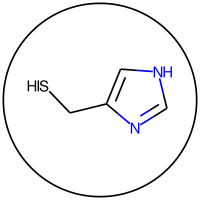

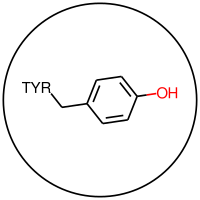

In [15]:
_ = Amino_Acids_SVGs['ASP'] 
#display(SVG(draw_amino_acid(_))) 
_ = Amino_Acids_SVGs['CYS'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['GLU'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['HIS'] 
display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['LYS'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['MET'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['THR'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['SER'] 
#display(SVG(draw_amino_acid(_)))
_ = Amino_Acids_SVGs['TYR'] 
display(SVG(draw_amino_acid(_)))

In [16]:
df = pd.read_pickle('data/df_processed.pkl') 

In [17]:
achor = Chem.MolFromSmarts('[#52,#83,#84]') 

sub = {
'ASP_OD1': Chem.MolFromSmiles('[O]C(=O)C[At]'            ),
'ASP_OD2': Chem.MolFromSmiles('[O]C(=O)C[At]'            ),
'CYS_SG' : Chem.MolFromSmiles('[S]C[At]'                 ),
'GLU_OE1': Chem.MolFromSmiles('[O]C(=O)CC[At]'           ),
'GLU_OE2': Chem.MolFromSmiles('[O]C(=O)CC[At]'           ),
'HIS_ND1': Chem.MolFromSmiles('[N+]1=CNC=C1(C[At])'     ),
'HIS_NE2': Chem.MolFromSmiles('[N]1C=C(C[At])[NH+]=C1'  ),
'LYS_NZ' : Chem.MolFromSmiles('[N]CCCC[At]'              ),
'MET_SD' : Chem.MolFromSmiles('[S+](C)CC[At]'            ),
'THR_OG1': Chem.MolFromSmiles('[O]C(C)[At]'              ),
'SER_OG' : Chem.MolFromSmiles('[O]C[At]'                 ),
'TYR_OH' : Chem.MolFromSmiles('[O]C(C=C1)=CC=C1C[At]'     )
}

df['adduct_pdb'] = df.apply(lambda x: Chem.ReplaceSubstructs(x.adduct_pdb, achor, sub[f'{x.res_name}_{x.res_atom_name}'])[0] , axis=1)

,adduct_smiles,binder_atom_name,binder_id_in_adduct,binder_mol,binder_smiles,binder_type,chain_id,chain_name,common_name,covalent_bond_record,doi,note,pdb_id,pdb_title,reaction_type,recovery_strategy,res_atom_name,res_name,res_num,unp_accessionid,unp_resnum,url,warhead_name,warhead_smarts,multistep,short_adduct_id,adduct_pdb,InChIKey,adduct_InChIKey,res_quad,binder_quad,binder_atom_alt,res_atom_alt,binder_chain_id,binder_num,drugbank_id,drugbank_groups,record_id,binder_id,full_residue_name,BindingDB_react_id
adduct_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1C7Q_A_HIS_306_?_ND1_?_A_BE1_500_?_C1_?,O=C(C[BiH2])NCCOP(=O)(O)O,C1,BE1,,O=C(CBr)NCCOP(=O)(O)O,inhibitor,A,PHOSPHOGLUCOSE ISOMERASE,NaN,"1C7Q,A,A,HIS,HIS,306,306,?,ND1,?,polymer,B,A,B...",10.1074/jbc.M002017200,NaN,1C7Q,THE CRYSTAL STRUCTURE OF PHOSPHOGLUCOSE ISOMER...,Addition-Elimination,manual,ND1,HIS,306,P13376,306,NaN,α-halogen,"[F,Cl,Br,I]C[#6,#7,#8]=,#,:[#6,#7,#8]",NaN,HIS_ND1_BE1_C1,,MUORYJVNLAHVKL-UHFFFAOYSA-N,HISJWWIPURRDBG-UHFFFAOYSA-O,1C7Q_A_306_HIS,1C7Q_A_500_BE1,?,?,A,500,NaN,NaN,CBR000001,CB0000001,Histidine,NaN
7C7P_A_CYS_145_?_SG_?_A_SV6_401_?_CAI_?,CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[...,CAI,SV6,,CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[...,inhibitor,A,main protease,NaN,"7C7P,A,A,CYS,CYS,145,145,?,SG,?,polymer,C,A,SV...",10.1126/science.abf1611,NaN,7C7P,Crystal structure of the SARS-CoV-2 main prote...,Addition,automatic,SG,CYS,145,P0DTD1,3408,NaN,Ketone,[#6]C(=O)[#6],NaN,CYS_SG_SV6_CAI,,BBAWEDCPNXPBQM-GDEBMMAJSA-N,MJKPHHNBENMLCV-ZXSLBYSHSA-N,7C7P_A_145_CYS,7C7P_A_401_SV6,?,?,A,401,DB05521,approved|withdrawn,CBR000002,CB0000002,Cysteine,NaN
1K54_A_SER_67_?_OG_?_A_HOQ_967_?_C1_?,CC(C)(O)[C@H](C(=O)[TeH])[C@@H]1N[C@@H](C(=O)O...,C1,HOQ,,CC1(C)S[C@@H]2[C@H](C(C)(C)O)C(=O)N2[C@H]1C(=O)O,inhibitor,A,Beta lactamase OXA-10,NaN,"1K54,A,A,SER,SER,47,67,?,OG,?,polymer,I,A,HOQ,...",10.1073/pnas.241442898,NaN,1K54,OXA-10 class D beta-lactamase partially acylat...,Ring-opening,automatic,OG,SER,67,P14489,67,NaN,β-lactam,O=[C;r4][N;r4],NaN,SER_OG_HOQ_C1,,GYVVHMGELBNZKP-GKROBHDKSA-N,UAXSFBADTRJISK-LYFYHCNISA-N,1K54_A_67_SER,1K54_A_967_HOQ,?,?,A,967,NaN,NaN,CBR000008,CB0000005,Serine,NaN
2QAF_A_LYS_138_?_NZ_?_A_U5P_3000_?_C6_?,O=c1cc([BiH2])n([C@@H]2O[C@H](COP(=O)(O)O)[C@@...,C6,U5P,,O=C1C=C(I)N(C(N1)=O)C2OC(C(C2O)O)COP(O)(O)=O,inhibitor,A,Orotidine 5' monophosphate decarboxylase,6-iodoUMP,"2QAF,A,A,LYS,LYS,157,138,?,NZ,?,polymer,C,A,U5...",10.1021/jm7010673,NaN,2QAF,Crystal structure of Plasmodium falciparum oro...,Addition,manual,NZ,LYS,138,Q8IJH3,138,NaN,Aryl_Halide,"c[F,Cl,Br,I]",NaN,LYS_NZ_U5P_C6,,VVCMFHKXDUPDFB-UHFFFAOYSA-N,WHFYARKLDSPCPP-YXZULKJRSA-N,2QAF_A_138_LYS,2QAF_A_3000_U5P,?,?,A,3000,NaN,NaN,CBR000029,CB0000015,Lysine,NaN
1LPN_A_HIS_449_?_NE2_?_A_DSC_561_?_S_?,CCCCCCCCCCCCS(=O)(=O)[BiH3-],S,DSC,,CCCCCCCCCCCCS(=O)(=O)Cl,inhibitor,A,LIPASE,NaN,"1LPN,A,A,HIS,HIS,464,449,?,NE2,?,polymer,G,A,D...",10.1021/bi00178a005,NaN,1LPN,ANALOGS OF REACTION INTERMEDIATES IDENTIFY A U...,Addition-Elimination,manual,NE2,HIS,449,P20261,464,NaN,Sulfonyl_Halide,"O=S(=O)([F,Cl,Br,I])[C,c]",NaN,HIS_NE2_DSC_S,,PBULHKIPTBIZHO-UHFFFAOYSA-N,UEOFUWUVWOZDAN-UHFFFAOYSA-O,1LPN_A_449_HIS,1LPN_A_561_DSC,?,?,A,561,NaN,NaN,CBR000035,CB0000019,Histidine,NaN
5TNE_A_ASP_129_?_OD1_?_A_7F6_401_?_C2_B,O[C@H](c1ccccc1)[C@H]([TeH])c1ccccc1,C2,7F6,,[C@H]1(c2ccccc2)O[C@H]1c3ccccc3,substrate,A,CFTR inhibitory factor,NaN,"5TNE,A,A,ASP,ASP,105,129,?,OD1,?,polymer,E,A,7...",10.1016/j.str.2017.03.002,cSO,5TNE,Crystal structure of the E153Q mutant of the C...,Ring-opening,manual,OD1,ASP,129,A0A0H2ZD27,129,NaN,Epoxide,C1OC1,NaN,ASP_OD1_7F6_C2,,ARCJQKUWGAZPFX-OKILXGFUSA-N,RBVZIRUQXNSUOK-KGLIPLIRSA-N,5TNE_A_129_ASP,5TNE_A_401_7F6,B,?,A,401,NaN,NaN,CBR000048,CB0000027,Aspartic Acid,NaN
1QI2_A_GLU_228_?_OE2_?_B_G2F_1_?_C1_?,OC[C@H]1O[C@H]([TeH])[C@H](F)[C@@H](O)[C@@H]1O,C1,G2F,,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])O[C@H]2...,inhibitor,A,ENDOGLUCANASE B,NaN,"1QI2,A,A,GLU,GLU,228,228,?,OE2,?,polym
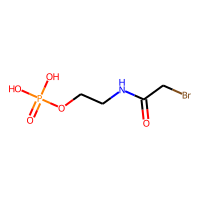
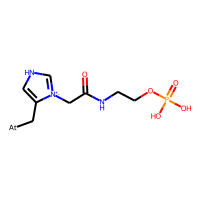
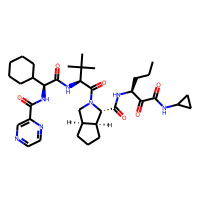
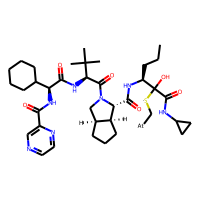
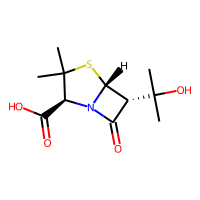
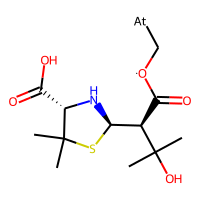
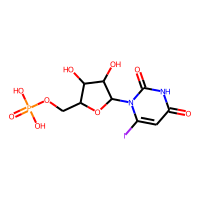
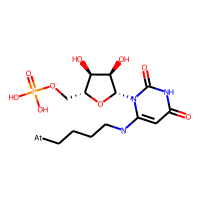
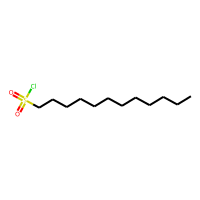
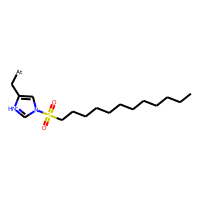
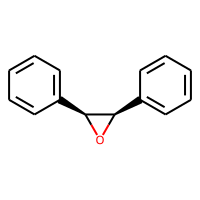
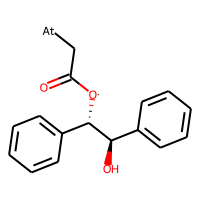
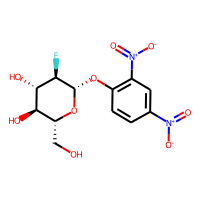
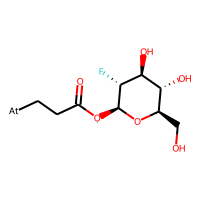
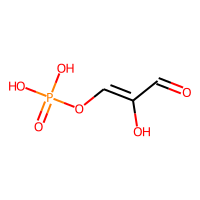
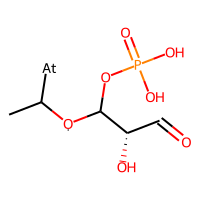
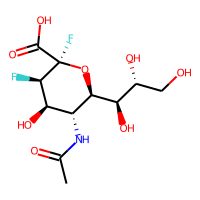
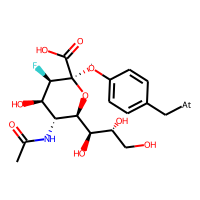
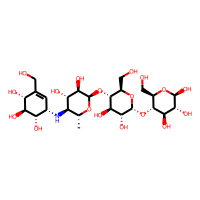
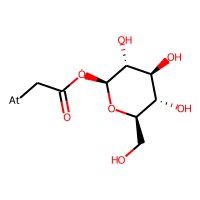
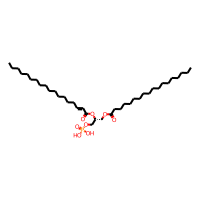
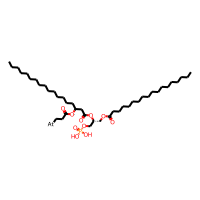
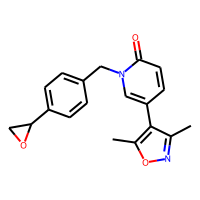
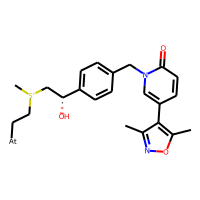

In [18]:
df.drop_duplicates(subset=['res_atom_name','res_name'])

In [19]:
import xml.etree.ElementTree as ET
def drawReactionInSVG(rctn1_svg, rctn2_svg, prdct_svg): 
    def get_shape(root):
        _1,_2,width,height=root.attrib['viewBox'].split()
        return int(width), int(height) 
    rctn1_root = ET.fromstring(rctn1_svg)
    rctn2_root = ET.fromstring(rctn2_svg)
    prdct_root = ET.fromstring(prdct_svg)
    
    rctn1_width, rctn1_height = get_shape(rctn1_root)
    rctn2_width, rctn2_height = get_shape(rctn2_root)
    prdct_width, prdct_height = get_shape(prdct_root)
    max_height  = max([rctn1_height, rctn2_height, prdct_height,10])
    half_height = max_height/2
    full_width  = rctn1_width + 10 + rctn2_width + 40 + prdct_width 
    
    svg = ET.Element('svg', attrib={'viewBox':f'0 0 {full_width} {max_height}', 'xmlns':"http://www.w3.org/2000/svg" })
    
    rctn1_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'rctn1'}) 
    for child in rctn1_root: 
        if child.tag == 'path' and child.get('class','foo') == 'foo': # highlight bond
            child.set('style','fill:none;fill-rule:evenodd;stroke:#FF7F7F;stroke-width:20px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1')
        #if child.tag.endswith('rect'): child.set('style', 'fill:black;stroke:1')
        #if child.tag=='ellipse': # highlight atom
        #    child.set('rx', '16')
        #    child.set('ry', '16')
        #    child.set('style', 'fill:none;stroke:red;stroke-width:4px;stroke-opacity:0.3')
        rctn1_symbol.append(child)
        
    plus_symbol  = ET.SubElement(svg, 'symbol', attrib={'id':'plus'})
    _ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'0', 'x2':'10', 'y1': '5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    _ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'5', 'x2': '5', 'y1': '0', 'y2':'10',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    
    rctn2_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'rctn2'}) 
    for child in rctn2_root:
        #if child.tag.endswith('rect'): child.set('style', 'fill:black;stroke:1')
        rctn2_symbol.append(child)
    
    arrow_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'arrow'})
    _ = ET.SubElement(arrow_symbol, 'line', attrib={'x1':'0', 'x2': '35', 'y1':'5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    _ = ET.SubElement(arrow_symbol, 'path', attrib={'d':'M 25 1 L 40 5 L 25 9 C 30 5 30 5 25 1', 'stroke-miterlimit':'1', 'stroke-width':'1'})
    
    prdct_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'prdct'}) 
    for child in prdct_root:
        #if child.tag.endswith('rect'): child.set('style', 'fill:black;stroke:1')
        prdct_symbol.append(child)    
         
    _ = ET.SubElement(svg, 'use', attrib={'href': '#rctn1', 'x':'0'                                , 'y':str(half_height-rctn1_height/2)})
    _ = ET.SubElement(svg, 'use', attrib={'href':  '#plus', 'x':str(rctn1_width)                   , 'y':str(half_height-5)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#rctn2', 'x':str(rctn1_width+10)                , 'y':str(half_height-rctn2_height/2)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#arrow', 'x':str(rctn1_width+10+rctn2_width)    , 'y':str(half_height-4)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#prdct', 'x':str(rctn1_width+10+rctn2_width+40) , 'y':str(half_height-prdct_height/2)})
    
    
    return ET.tostring(svg, encoding="unicode") 

In [20]:
from matplotlib.colors import ColorConverter 
color_code_red = ColorConverter().to_rgb('red')
def get_proper_size(m):
    drawer = rdMolDraw2D.MolDraw2DSVG(5000,5000)
    drawer.ClearDrawing()
    drawer.SetDrawOptions(op)
    m = rdMolDraw2D.PrepareMolForDrawing(m)
    drawer.DrawMolecule(m)
    drawer.FinishDrawing()

    _ = re.findall("(?<=d\=\').*?(?=\')",  drawer.GetDrawingText(), re.DOTALL)
    _ = ' '.join(_)
    _ = re.sub('[a-zA-Z,\n,\-]', ' ', _)
    _ = [float(f) for f in _.split()]
    _ = int(max(_) - min(_)) + 1
    return _, _

from PIL import Image, ImageChops
def get_proper_size1(m):
    im = Chem.Draw.MolToImage(m, size=(5000,5000))
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox() 
    width, height = (bbox[2]-bbox[0],bbox[3]-bbox[1])
    return width, height
    if bbox: return im.crop(bbox)
                          

In [21]:
def draw_reaction(row): 
    try:
        _ = row['covalent_bond_record'].split(',')
        adduct_id = '_'.join([_[i] for i in [0,2,4,6,7,8,9,12,14,16,17,18,19]])
        file_path = f"/scratch/xg590/scratch/PDBcov/VueJs/s/img/reaction/{adduct_id}.svg" 
        if os.path.exists(file_path): return None
        binder_mol = row['binder_mol'] 
        try:
            warhead_atom_idxs = binder_mol.GetSubstructMatches(Chem.MolFromSmarts(row['warhead_smarts']))
        except:
            warhead_atom_idxs = [] 
        res_svg = Amino_Acids_SVGs[row['res_name']] 
        adduct_pdb = row['adduct_pdb'] 
        size = get_proper_size(adduct_pdb)   
        drawer = rdMolDraw2D.MolDraw2DSVG(*size)
        drawer.SetDrawOptions(op)
        try:
            At_idx = [a.GetIdx() for a in adduct_pdb.GetAtoms() if a.GetSymbol()=='At'][0]
        except:
            print(f"At is not found [{row['record_id']}]")
            return None
        opts = drawer.drawOptions()
        opts.atomLabels[At_idx]=row['res_name']
        adduct_pdb = Draw.rdMolDraw2D.PrepareMolForDrawing(adduct_pdb)
    
        drawer.DrawMolecule(adduct_pdb)
        drawer.FinishDrawing()
        adduct_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')
    
        size = get_proper_size(binder_mol)   
        binder_mol = rdMolDraw2D.PrepareMolForDrawing(binder_mol)
        drawer = rdMolDraw2D.MolDraw2DSVG(*size)
        drawer.SetDrawOptions(op)
        if len(warhead_atom_idxs) != 1:
            drawer.DrawMolecule(binder_mol)
        else:
            indi_op = drawer.drawOptions() 
            drawer.DrawMolecule(binder_mol, highlightAtoms=warhead_atom_idxs[0]) 
    
        drawer.FinishDrawing()
        binder_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=') 
        reaction_svg = drawReactionInSVG(binder_svg, res_svg, adduct_svg) 
        #display(SVG(reaction_svg)) 
        with open(file_path, 'w') as fw:
        #    #fw.write('<!DOCTYPE html><html lang="en-us" dir="ltr" ><body>\n\n')
            fw.write(reaction_svg)
        #    #fw.write('\n\n</body></html>') 
    except:
        return None
draw_reaction(df[['binder_mol', 'warhead_smarts', 'adduct_pdb', 'res_name', 'record_id', 'covalent_bond_record']].to_dict('row')[0])

In [22]:
import multiprocessing
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    p.map(draw_reaction, df[['binder_mol', 'warhead_smarts', 'adduct_pdb', 'res_name', 'record_id', 'covalent_bond_record']].to_dict('row'), multiprocessing.cpu_count())

At is not found [CBR006287]
